In [1]:
# # Run this cell to mount your Google Drive.
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
import json
import pandas as pd
import numpy as np
import nltk
import spacy
from datetime import datetime
import gensim
import gensim.corpora as corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile, datapath
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")

In [0]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

The JSON file contains the following data points:  
*  **url** - The Url of the article  
*  **etitile** - Title of the article  
*  **keywords** - Keywords related to the article, includes keywords which are found in meta tags  
*  **description** - First 100-150 characters of content  
*  **modified_date** - Article published date  
*  **body** - Content of the article  
*  **htitle** - Title found in the header  
*  **author** - Author of the article  
*  **id** - Id of Article  

## CLEANING

#### Converting JSON files to pandas df

In [0]:
# # Each JSON is a row
# df = pd.DataFrame()
# number_of_files = 16494
# for i in range(number_of_files):
#     file = open(f"./data-final/{i}.json", 'r')
#     s = file.read()
#     data = json.loads(s)
#     dfi = pd.DataFrame([data])
#     df = pd.concat([df, dfi], ignore_index=True)

# # Saving df as a pickle
# df.to_pickle('./data.pkl')

In [0]:
raw_df = pd.read_pickle('./data.pkl')

In [0]:
def clean_data(raw_df):
    '''
    Input: raw dataframe in .pkl format
    Output: clean datafram
    '''
    
    def convert_to_dt(s):
        try:
            return datetime.strptime(s[5:-6], '%d %b %Y %H:%M:%S')
        except Exception:
            return np.nan            
    
    df = raw_df[['id', 'modified_date', 'etitle', 'body']]                        # Extracting only useful columns into another df   
    df.columns = ['article_ID', 'publish_date', 'title', 'body']                  # Renaming columns
    
    df.drop_duplicates(subset=list(df.columns), keep='first', inplace=True)       # dropping dupliacte rows
    
    df['article_ID'] = df[df['article_ID'].map(len) <= 8]                         # Cleaning id and dropping null values (9 null values found in date)
    df.dropna(inplace=True)
    
    df['article_ID'] = df['article_ID'].astype('int64')                           # Converting id to int from string
    
    
    df['publish_date'] = df['publish_date'].apply(convert_to_dt)
    df.dropna(inplace=True)                                                       # Some date values were corrupted so dropped them
    
    df.sort_values(by='publish_date', axis=0, inplace=True)
    df.drop_duplicates(subset=['body'], keep='first', inplace=True)               # There were repeated values in the body column, so dropped all except the one published first
    
    return df

In [0]:
df = clean_data(raw_df)

In [0]:
df.head()

,article_ID,publish_date,title,body
208,2000919,2019-03-01 00:01:46,"PM Narendra Modi: ""Scientists And Researchers ...",Prime Minister Narendra Modi on Thursday urged...
207,2000920,2019-03-01 00:01:47,Union Cabinet Approves Setting Up Of AIIMS In ...,The Union Cabinet on Thursday approved setting...
206,2000923,2019-03-01 00:12:25,Afghan Man Trying To Smuggle 32 kg Gold In Fru...,"In a big haul, the Customs Department on Thurs..."
205,2000924,2019-03-01 00:13:17,China Says North Korean Nuclear Issue Can't Be...,Beijing expressed hope Thursday that the US an...
204,2000925,2019-03-01 00:21:56,CRPF Soldier Injured In Pulwama Attack Returns...,Two weeks after he was injured in the Pulwama ...


In [0]:
# pd.to_pickle(df, './drive/My Drive/clean_data.pkl')

In [0]:
# Helper Functions

def article_to_words(articles):
    '''tokenizes articles; yeilds list of words for each article'''
    for article in articles:
        yield(gensim.utils.simple_preprocess(article, deacc=True))  # deacc=True removes punctuations
        
def remove_stopwords(texts):
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'say', 'also', 'would', 'may'])
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    '''Applies the bigram model(defined below) on each document'''
    return [bigram_mod[doc] for doc in texts]

nlp = spacy.load('en', disable=['parser', 'ner'])
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [0]:
def preprocess(df):
    '''
    Input: clean dataframe
    Output: list of articles after preprocess, bigram model
    '''
    
    articles = list(df['body'])                                          # Corpus of content of all articles
    data_words = list(article_to_words(articles))                        # Each article is a list of all it's words after "simple_preprocess"
    
    common_terms = ["of", "with", "without", "and", "or", "the", "a"]
    bigram = gensim.models.Phrases(data_words, 
                                   min_count=4, 
                                   threshold=30, 
                                   common_terms=common_terms)            # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)                   # wrapper
    
    return data_words, bigram_mod

In [0]:
data_words, bigram_mod = preprocess(df)

data_words_lemmatized = lemmatization(data_words)
data_words_nostops = remove_stopwords(data_words_lemmatized)
data_final = make_bigrams(data_words_nostops)

**Side notes**
 - The threshold parameter in bigram model:  
 A phrase of words a and b is accepted if 
        (cnt(a, b) - min_count) * N / (cnt(a) * cnt(b)) > threshold
 So basically, higher threshold implies that it is phrases with high frequency will be identified.
 
 - The common_terms parametet in bigram model:  
 List of “stop words” that won’t affect frequency count of expressions containing them. Allow to detect expressions like “bank_of_america” or “eye_of_the_beholder”.

In [0]:
word_dict = corpora.Dictionary(data_final)

# Bag of words (Document Term Frequency)
# list of tuples for each doc- (id,frequency) of word in that document
corpus = [word_dict.doc2bow(text) for text in data_final] 

## MODELLING

### Topic Modelling with LDA

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models`
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=word_dict,
                                           num_topics=num_topics,
                                           random_state=100,
                                           passes=20,
                                           per_word_topics=True,
                                           workers=25)
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(num_topics)

    return model_list, coherence_values

start=5; limit=30; step=5
model_list, coherence_values = compute_coherence_values(dictionary=word_dict, corpus=corpus, texts=data_final, start=start, limit=limit, step=step)

5
10
15
20
25


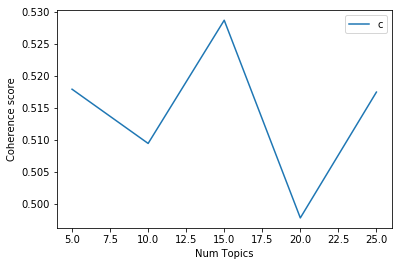

In [0]:
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

The coherence value seems to be highest (~0.52) for 15 topics

In [0]:
model_lda = model_list[coherence_values.index(max(coherence_values))]  # Model with highest coherence
# model_lda.show_topics(-1)

# Saving model to disk
temp_file = datapath("model_lda")
model_lda.save(temp_file)

# To load from disk: model_lda = LdaModel.load(temp_file)

### Doc2Vec

In [0]:
def doc2vec(data_final):
    '''
    Input: Cleaned and preprocessed data
    Output: doc2vec model trained on given data
    '''
    
    tagged_data = [TaggedDocument(words=words, tags=[str(i)]) for i, words in enumerate(data_final)]  # tagging documents
    model = Doc2Vec(tagged_data, window=4, min_count=1, workers=10)
    
    return model

In [0]:
model_doc2vec = doc2vec(data_final)

# Saving model to disk
fname = get_tmpfile("model_doc2vec")
model_doc2vec.save(fname)

# To load from disk: model = Doc2Vec.load(fname)

In [0]:
def update_models(new_raw_data, model_lda):
    '''
    Updates the LDA and Doc2Vec model given new raw data
    Input:  new raw data in .pkl format, old lda model
    Output: new lda model, new d2v model
    '''
    
    global raw_df
    
    new_raw_combined = pd.concat([new_raw_data, raw_df])                            # Combining original data and new data
    
    # cleaning
    new_df_combined = clean_data(new_raw_combined)                                  # combined                                 
    new_df = clean_data(new_raw_data)                                               # only new
    
    # preprocessing
    # combined
    data_words_combined, bigram_mod_combined = preprocess(new_df_combined)

    data_words_lemmatized_combined = lemmatization(data_words_combined)       
    data_words_nostops_combined = remove_stopwords(data_words_lemmatized_combined) 
    data_final_combined = make_bigrams(data_words_nostops_combined)
    
    # only new
    data_words, bigram_mod = preprocess(new_df)
    
    data_words_lemmatized = lemmatization(data_words)       
    data_words_nostops = remove_stopwords(data_words_lemmatized) 
    data_final = make_bigrams(data_words_nostops)
    
    # Updating the LDA model with the new corpus (only new)
    new_word_dict = corpora.Dictionary(data_final)
    new_corpus = [new_word_dict.doc2bow(text) for text in data_final]                # Bag of words (Document Term Frequency)
    model_lda.update(new_corpus)
    
    # Currently, there is no way to update a pretrained doc2vec model so we need to retrain the whole thing (combined)
    new_doc2vec = doc2vec(data_final_combined)
    
    return model_lda, new_doc2vec